In [1]:
import numpy as np
from matplotlib import pyplot as plt

#configure plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib
matplotlib.rcParams['figure.figsize'] =  (8,5)
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['font.family'] = 'serif'

np.random.seed(0)
import sys
sys.path.append('/Users/danmarthaler/GPclust')

#Mixture of Gaussians with GPclust

###James Hensman, November 2014
###Daniel Marthaler September 2016

This is a very simple demo to show how to use GPclust to build a mixture of Gaussians. We'll grab some toy data, fit the model and do some very simple analyis of the posterior. We'll also have a look at the truncated Dirichlet process approximation, and how to run a merge-split method to find the optimal number of clusters. Finally we'll examine the effect of changing the priors over the cluster components. 

In [2]:
X = np.load('twoD_clustering_example.npz')['X']
print(X.shape)

(506, 2)


We have a two-dimensional dataset, with 506 data.

Building the model is as simple as importing the GPclust library and calling the class constructor with our data. The argument num_clusters specifies how many clusters to use.

In [3]:
import GPclust
m = GPclust.MOG(X, num_clusters=10)

For two-dimensional data, there's a handy built-in plot function:

In [6]:
def plot(model,X):
    from matplotlib import pyplot as plt
    from scipy import stats

    xmin, ymin = X.min(0)
    xmax, ymax = X.max(0)
    xmin, xmax = xmin-0.1*(xmax-xmin), xmax+0.1*(xmax-xmin)
    ymin, ymax = ymin-0.1*(ymax-ymin), ymax+0.1*(ymax-ymin)
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    Xgrid = np.vstack((xx.flatten(), yy.flatten())).T

    plt.figure()
    zz = m.predict(Xgrid).reshape(100, 100)
    zz_data = m.predict(X)

    plt.contour(xx, yy, zz, [stats.scoreatpercentile(zz_data, 5)], colors='k', linewidths=3)
    plt.scatter(X[:,0], X[:,1], 30, np.argmax(m.get_phi(), 1), linewidth=0, cmap=plt.cm.gist_rainbow)

    zz_components = m.predict_components(Xgrid)
    phi_hat = m.get_phihat()
    pie = phi_hat+m.alpha
    pie /= pie.sum()
    zz_components *= pie[np.newaxis,:]
    [plt.contour(xx, yy, zz.reshape(100, 100), [stats.scoreatpercentile(zz_data, 5.)], colors='k', linewidths=1) for zz in zz_components.T]
    plt.show()

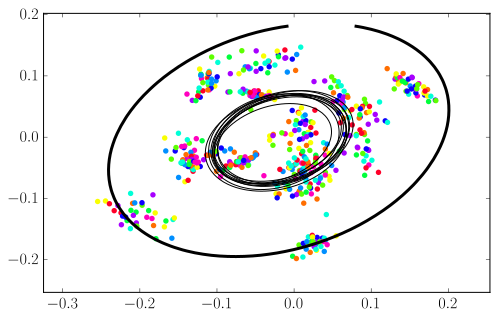

In [7]:
plot(m,X)

Here, the data are colored according to the (most probably) assigned cluster, and the heavy line(s) show the contours of the models probability density. Thin lines show the countours of the probablity density of each component.

We can see that the model has not been fitted yet! The variational approximation to the posterior is initialized randomly, i.e. all data are randomly assigned across the clusters. To fit the approximation, call the optimize routine, and plot again. 

In [8]:
m.optimize()

iteration 1 bound=840.246014825 grad=308.777145575, beta=0
iteration 2 bound=840.904453584 grad=0.561304642295, beta=0.000145126967797
iteration 3 bound=844.313288069 grad=1.08970471668, beta=1.72739699282
iteration 4 bound=862.667192938 grad=4.4287441359, beta=2.10339951231
iteration 5 bound=905.364291219 grad=20.0075932917, beta=1.69036898367
iteration 6 bound=942.805723327 grad=32.1455467813, beta=0.872266315458
iteration 7 bound=957.192541464 grad=16.2657449467, beta=2.01942104877
iteration 8 bound=979.483253179 grad=26.1791267443, beta=0.0
iteration 9 bound=997.650732933 grad=20.1588678969, beta=0.0
iteration 10 bound=1025.24614454 grad=24.7127078571, beta=0.776332812145
iteration 11 bound=1055.84290373 grad=22.6919812444, beta=0.804864402663
iteration 12 bound=1090.62196011 grad=29.3128570809, beta=1.14300857503
iteration 13 bound=1119.86720392 grad=31.4465758757, beta=0.790716925372
iteration 14 bound=1157.89806837 grad=29.6376075378, beta=2.67596965734
iteration 16 bound=1183.9

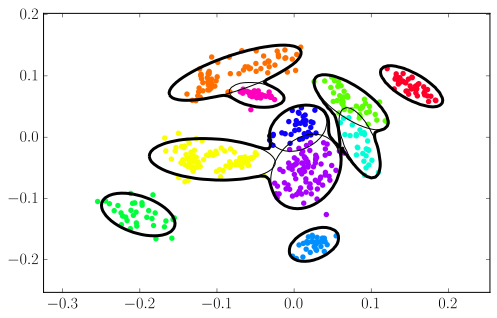

In [9]:
plot(m,X)

#Dirichlet process priors and the merge-split method
Instead of using a fixed number of clusters, we can place a Dirichlet process prior over the component weights: effectively a prior of an infintie number of clusters. The variational approximation is _truncated_ se we still only model a finite number of clusters, but now we can optimize for the number of components.

To help explore the search space, GPclust has a `try_split` function. This re-initialized the posterior with a cluster 'split' into two. Attempted splits are only accepted if the bound onthe marginal likelihood increases.  A wrapper around the `try_split()`, method, `systematic_splits()` repeatedly attempts splits. 

Let's build a MOG with a DP prior, truncated at four components:

In [10]:
m = GPclust.MOG(X, num_clusters=4, prior_Z='DP', alpha=10.)
m.optimize()

iteration 1 bound=912.912321583 grad=199.871288413, beta=0
iteration 2 bound=913.238077848 grad=0.287669398797, beta=0.0
iteration 3 bound=914.779819466 grad=0.504861692779, beta=1.7018427199
iteration 4 bound=923.26792146 grad=1.87483407647, beta=2.03586496767
iteration 5 bound=951.315461839 grad=8.90440027228, beta=1.87004357233
iteration 6 bound=983.686950058 grad=21.7472833089, beta=1.10669927656
iteration 7 bound=999.011696975 grad=15.0798062477, beta=0.555846704984
iteration 8 bound=1003.79744999 grad=5.72108946538, beta=0.0
iteration 9 bound=1007.71392189 grad=4.24575056124, beta=0.0
iteration 10 bound=1016.46421064 grad=4.26459307719, beta=1.40083440032
iteration 11 bound=1034.02866214 grad=6.65862490383, beta=1.58649875387
iteration 12 bound=1048.69215449 grad=12.6423284573, beta=0.970727533451
iteration 13 bound=1059.43899715 grad=9.84814047171, beta=0.661026235304
iteration 14 bound=1072.73503002 grad=11.0329176247, beta=1.00729590219
iteration 15 bound=1083.06158849 grad=9.

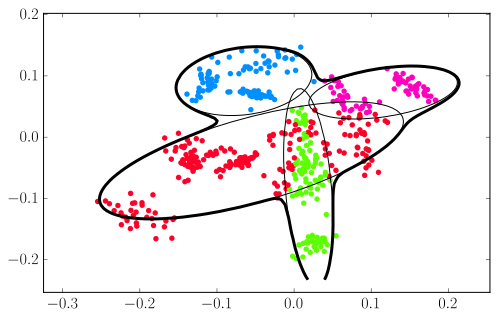

In [11]:
plot(m,X)

With only four components, the fit is quite poor. To attempt to split the $i^\textrm{th}$ component, call `try_split(i)`. The method returns `True` if the split was sucessful, and displays the current status after each split attempt. 

In [12]:
m.try_split(1)


attempting to split cluster  1
iteration 1 bound=1147.75426317 grad=44.4439736738, beta=0
iteration 2 bound=1157.49706587 grad=9.57824166821, beta=0.0
iteration 3 bound=1174.32643979 grad=42.7218185339, beta=0.905043412012
iteration 4 bound=1179.42216931 grad=9.85957028884, beta=0.0666188780899
iteration 5 bound=1180.70523968 grad=2.24975626849, beta=0.0
iteration 6 bound=1181.0242226 grad=0.424751644893, beta=0.219267809563
iteration 7 bound=1181.10305882 grad=0.0771837015928, beta=0.131267775687
iteration 8 bound=1181.16244142 grad=0.0426311996239, beta=0.463906678848
iteration 9 bound=1181.20120317 grad=0.0216771404787, beta=0.578091682653
iteration 10 bound=1181.21903092 grad=0.0088090936028, beta=0.491532544505
iteration 11 bound=1181.22649282 grad=0.00450356218002, beta=0.303357813347
iteration 12 bound=1181.2326204 grad=0.00347746611689, beta=0.477204593502
iteration 13 bound=1181.23853512 grad=0.00284357196998, beta=0.607673333558
iteration 14 bound=1181.24446863 grad=0.002336

True

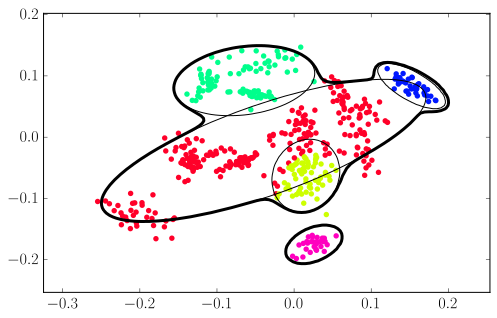

In [13]:
plot(m,X)

We can see that in attempting to split the first cluster, the bound on the marginal likelihood has increased and the move was accepted. To save having to repeatedly call the `try_split` method, there's a helpful `systematic_splits()` function, which iterates through each cluster and attempts to split it until the marginal-likelihood bound fails to increase. Here we'll turn the output off, as it can get a bit long.

In [14]:
m.systematic_splits(verbose=False)

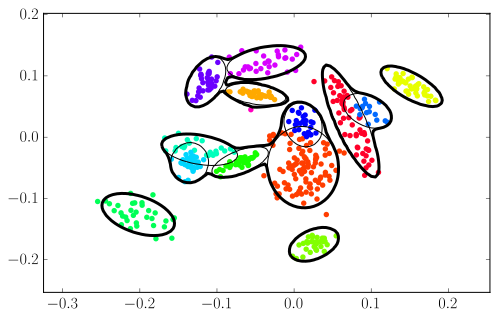

In [15]:
plot(m,X)

##Getting at the parameters of the posterior. 
There are perhaps three main tasks that we'd like to do with the fitted model:
* See which data are assigned to the same cluster
* Examine the means (and variances) of the cluster components
* Predict the probability density at a new point

The posterior over data assignments is stored in a matrix called `phi`. This matrix is NxK, and each element $\phi_{nk}$ represents the probability that the $n^\textrm{th}$ datum is assigned to the $k^\textrm{th}$ component. Here we'll visualize the posterior assignment probabilities in a heatmap-style plot.

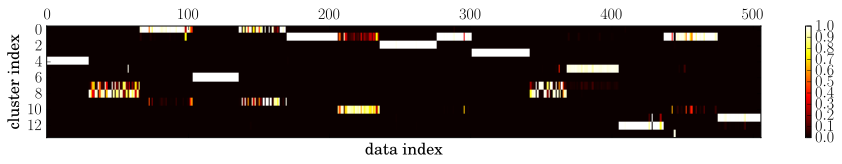

In [16]:
phi = m.get_phi()
_=plt.matshow(phi.T, cmap=plt.cm.hot, vmin=0, vmax=1, aspect='auto')
plt.xlabel('data index')
plt.ylabel('cluster index')
_=plt.colorbar()

The variational posterior for each of the components in the MOG model is a Gaussian-Wishart distribution. These are stored in the model as so:

In [17]:
mun, Sns = m.get_means_and_covariances()
print 'first component mean:', mun[:,0]
print 'first component covariance:\n', Sns[:,:,0]


first component mean: [ 0.07348073  0.01166369 -0.04973539  0.15236904  0.02573559 -0.06995239
 -0.20205162 -0.12248983 -0.13554536  0.0952185   0.01178856 -0.11459271
 -0.03650353 -0.05579827]
first component covariance:
[[  1.76803421e-02  -3.66424741e-02]
 [  4.95991472e-02  -2.50874905e-03]
 [  8.60505123e-03  -1.45484841e-03]
 [  1.10918878e-02  -6.50374245e-03]
 [  5.55919732e-03   1.89468203e-03]
 [  7.78441323e-03   3.28198253e-03]
 [  2.19296769e-02  -6.93189862e-03]
 [  1.79051958e-02  -3.20060336e-03]
 [  3.53275537e-03   1.66227415e-04]
 [  4.33178376e-03  -1.49442159e-03]
 [  3.37242541e-03  -7.39435355e-04]
 [  4.05952611e-03   2.93132345e-03]
 [  2.14417683e-02   4.06098498e-03]
 [  1.01502813e-03  -3.14416346e-06]]


Finally, to obtain the predictive density of the model at any point, we can use `m.predict`. To get the density under each of the components, we can use `m.predict_components'.

In [18]:
test_point = np.array([[0.1, 0.0]])
density = m.predict(test_point)
print 'model density:',density

cw_density = m.predict_components(test_point)
print 'density under each component:', cw_density.round(3)


model density: [ 6.32392843]
density under each component: [[  5.99830000e+01   3.10000000e-02   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.01230000e+01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   3.11000000e-01]]


##Adjusting the prior parameters
The MOG model has priors over the component means and covariances (Gaussian Wishart) and a Dirichlet (or Dirichlet-process) prior over the mixing proportions. We'll use the 2D dataset to illustrate how to change these prior parameters and the effect of them. 

First, let's place a strong prior over the cluster covariances that forces them to be small, and a large concentration parameter, which makes the Dirichlet process prefer a large number of clusters. 



In [19]:
print m.log_likelihood()

1401.1080071


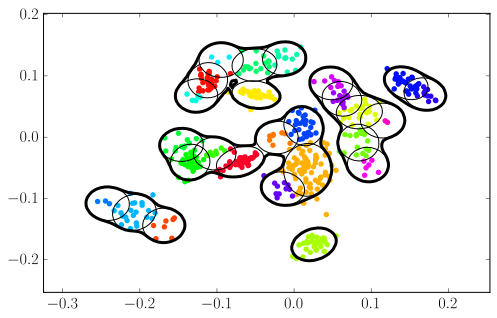

bound on the marginal likelihood: 2981.57178402


In [20]:
m = GPclust.MOG(X, num_clusters=10, prior_S=np.eye(2)*5e-3, prior_v=30., prior_Z='DP', alpha=100)
m.optimize(verbose=False)
m.systematic_splits(verbose=False)
m.systematic_splits(verbose=False)
plot(m,X)
print 'bound on the marginal likelihood:', m.log_likelihood()

We see that the model finds a very large number of small clusters! Now let's see what happens if we relax the concentration parameter, and reduce the strength of the Wishart prior:

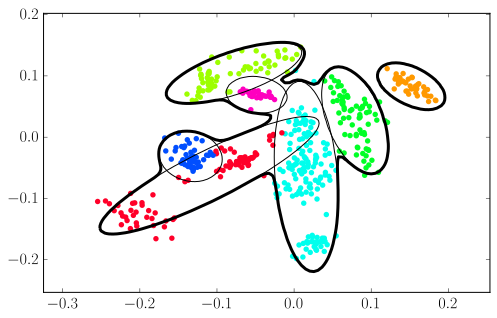

bound on the marginal likelihood: 1457.56946763


In [21]:
m = GPclust.MOG(X, num_clusters=10, prior_S=np.eye(2)*5e-3, prior_v=10., prior_Z='DP', alpha=0.1)
m.optimize(verbose=False)
m.systematic_splits(verbose=False)
m.systematic_splits(verbose=False)
plot(m,X)
print 'bound on the marginal likelihood:', m.log_likelihood()

The MOG also takes a prior mean parameter (which defalts to the mean of the data) and a prior concentration parameter as part of the Wishart distribution. We leave experimenting with these to the reader. 